# EDA: Exploratory Data Analysis of 3 SuperBird datasets
Datasets included in the analysis:
- Cowbird
- CUB_200_2011
- tiny_nabirds

In [2]:
# imports
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from src.data import *
from src.calcs import *
from src.utils import *
from src.visualisation import *

In [5]:
# data loading
root = "/home/dikra/media/dikra/PhD/DATA/DLC24_Data/tiny_all_bird_merged_coco"
images = f"{root}/images"
annotations = f"{root}/annotations"
train_file = f"{annotations}/train.json"
test_file = f"{annotations}/test.json"

train_data = load_data(train_file)
test_data = load_data(test_file)

## High-level view of the datasets

Plotting how many keypoints and annotations there are in each dataset out of the total merged dataset, divided by train and test sets, to get an idea of data distributions across test and train datasets.
We can consider 1 annotation to reflect one set of keypoints, or one bounding box, i.e. one animal. 

In [4]:
#The following data block uses the merged dataset to compare annotated number of keypoints and annotations across merged datasets.
#Train data
train_annotations_by_dataset, train_keypoints_by_dataset = count_keypoints_annotations(train_data)
train_annotations_by_dataset, train_keypoints_by_dataset

#Test data
test_annotations_by_dataset, test_keypoints_by_dataset = count_keypoints_annotations(test_data)
test_annotations_by_dataset, test_keypoints_by_dataset


({'tiny_nabirds': 100, 'cowbird': 56, 'CUB_200_2011': 100},
 {'tiny_nabirds': 734, 'cowbird': 408, 'CUB_200_2011': 1075})

In [5]:
# Prepare data for pie charts
#Train data
train_keypoints_labels = list(train_keypoints_by_dataset.keys())
train_keypoints_sizes = list(train_keypoints_by_dataset.values())

train_annotations_labels = list(train_annotations_by_dataset.keys())
train_annotations_sizes = list(train_annotations_by_dataset.values())

#Test data
test_keypoints_labels = list(test_keypoints_by_dataset.keys())
test_keypoints_sizes = list(test_keypoints_by_dataset.values())

test_annotations_labels = list(test_annotations_by_dataset.keys())
test_annotations_sizes = list(test_annotations_by_dataset.values())

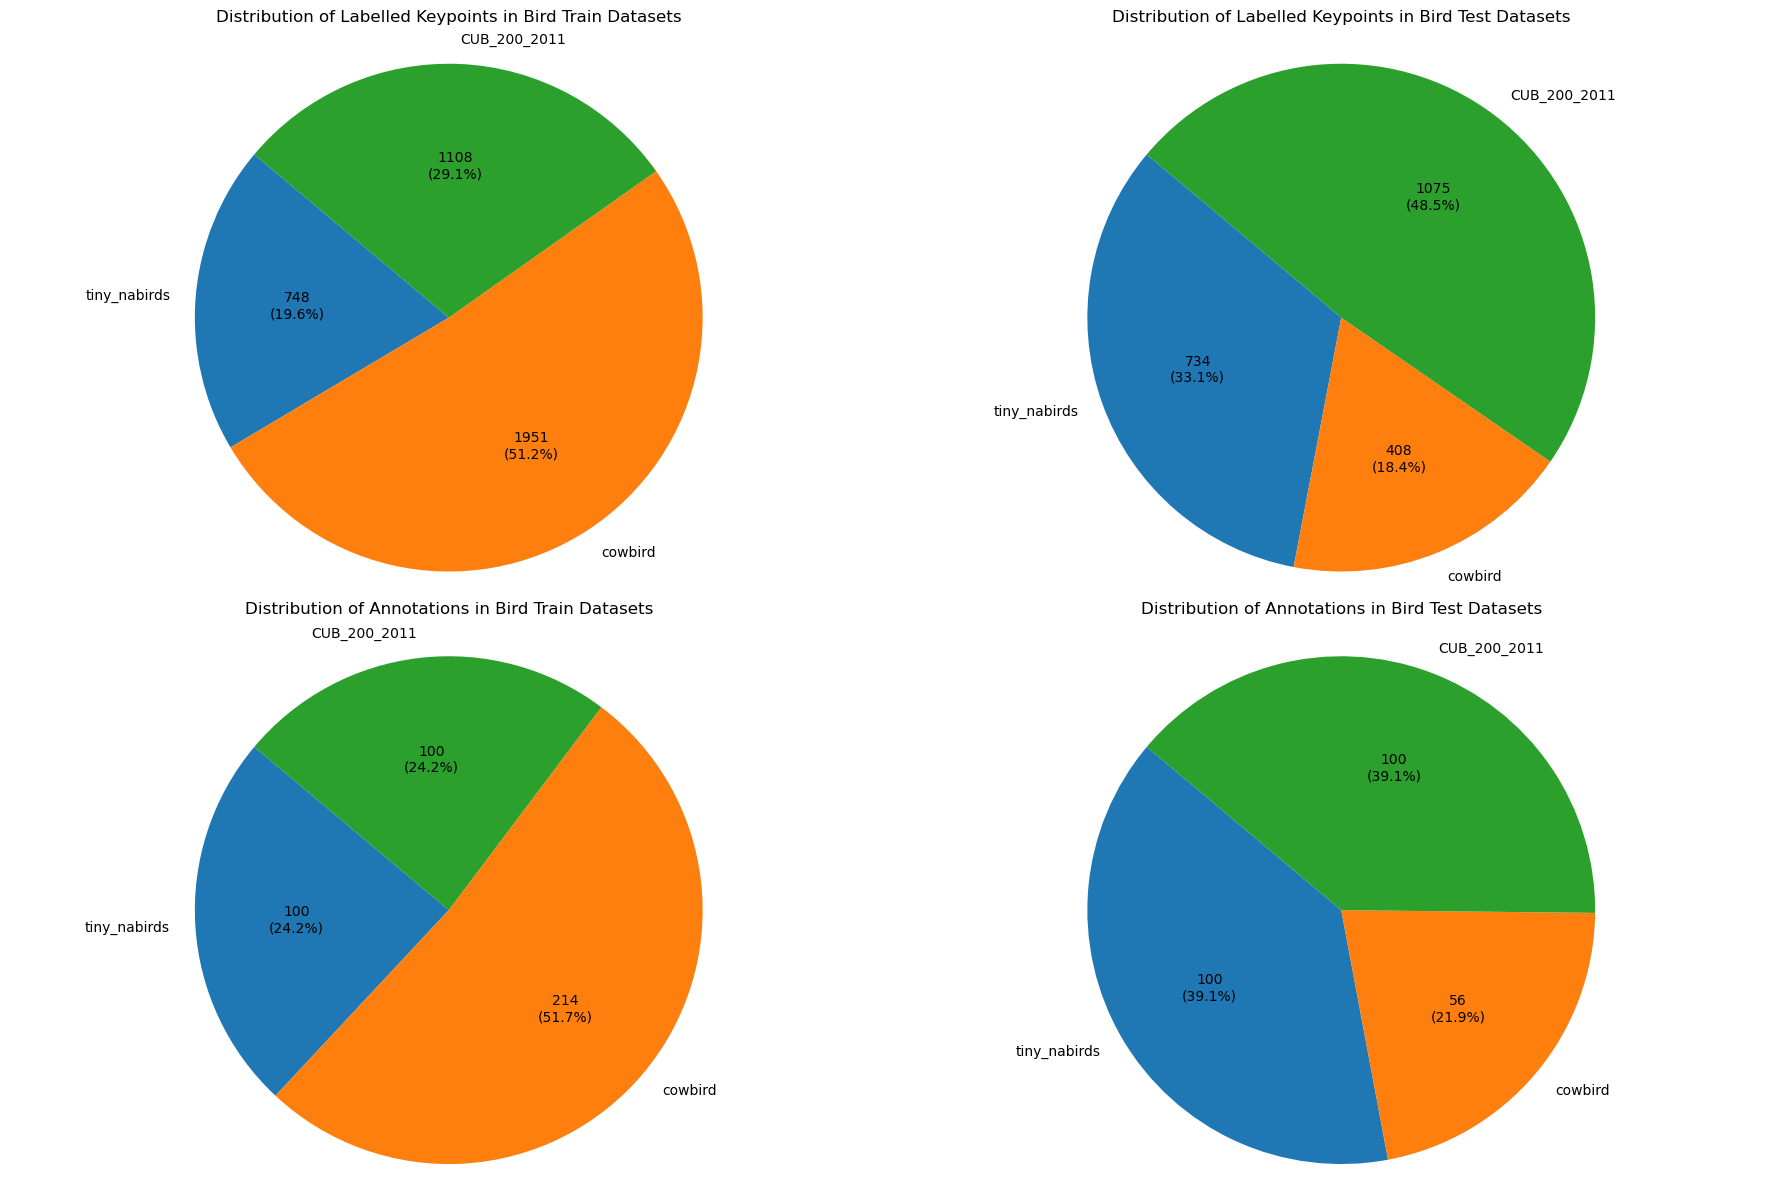

In [6]:
# Plot the pie charts in a grid
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Adjust the spacing at the top to avoid overlap
fig.subplots_adjust(top=0.85)

## Plot the pie charts
# Train data keypoints pie chart
axs[0, 0].pie(train_keypoints_sizes, labels=train_keypoints_labels, autopct=autopct_format(train_keypoints_sizes), startangle=140, textprops={'fontsize': 10})
axs[0, 0].axis('equal')
axs[0, 0].set_title('Distribution of Labelled Keypoints in Bird Train Datasets', pad=20)

# Train data annotations pie chart
axs[1, 0].pie(train_annotations_sizes, labels=train_annotations_labels, autopct=autopct_format(train_annotations_sizes), startangle=140, textprops={'fontsize': 10})
axs[1, 0].axis('equal')
axs[1, 0].set_title('Distribution of Annotations in Bird Train Datasets', pad=20)

# Test data keypoints pie chart
axs[0, 1].pie(test_keypoints_sizes, labels=test_keypoints_labels, autopct=autopct_format(test_keypoints_sizes), startangle=140, textprops={'fontsize': 10})
axs[0, 1].axis('equal')
axs[0, 1].set_title('Distribution of Labelled Keypoints in Bird Test Datasets', pad=20)

# Test data annotations pie chart
axs[1, 1].pie(test_annotations_sizes, labels=test_annotations_labels, autopct=autopct_format(test_annotations_sizes), startangle=140, textprops={'fontsize': 10})
axs[1, 1].axis('equal')
axs[1, 1].set_title('Distribution of Annotations in Bird Test Datasets', pad=20)

plt.tight_layout()
plt.show()

Top row: Distribution of keypoints across the datasets between train (left) and test (right) data from the merged datasets. 
Bottom row: Distribution of annotations across datasets between train (left) and test (right) data from the merged datasets.

All 3 datasets were split into 100 train and 100 test images. The cowbird dataset generally has multiple birds within the same picture, which could explain why it makes up a greater percentage of the number of annotations and key points in the train set, given that multiple annotations and corresponding key points may exist within a single image. On the other hand, the cowbird dataset makes up less of the labelled key points and annotations in the test set, possibly if not all the test images were annotated, and/or the test set had fewer birds in the images.

## BBox VS Image proportion

Here we investigate how much of an image is made up of the animal on each bird dataset. As 2 out of 3 datasets did not contain segmentation masks, this is conducted using the boundingbox coordinates.

As the cowbird dataset used a boundingbox notation of bbox = [x1, y1, width, height], while the remaining datasets used notation of bbox = [x1, y1, x2, y2], how bbox size is calculated is specified based on manual inspection of the bbox visualizations to infer what notation they have. Ideally, this calculation should be optimized for automatized assesment of bbox coordinate notation.

As the cowbird dataset included more than 1 bird per picture, the bird/image size ratio can be calculated for each individual bird as a proportion of total image size (automatically applied to all datasets with 1 bird per image), or as a sum of all bird bboxes as a proportion of total image size. Both methods are included in first and second plot, respectively.

The plots reflect the train and test data from the merged data, for each dataset individually.

In [6]:
#Prepare data using single bbox method 
train_proportions_by_dataset = extract_bbox_proportions(train_data)
test_proportions_by_dataset = extract_bbox_proportions(test_data)

{'tiny_nabirds': 100, 'cowbird': 214, 'CUB_200_2011': 100}

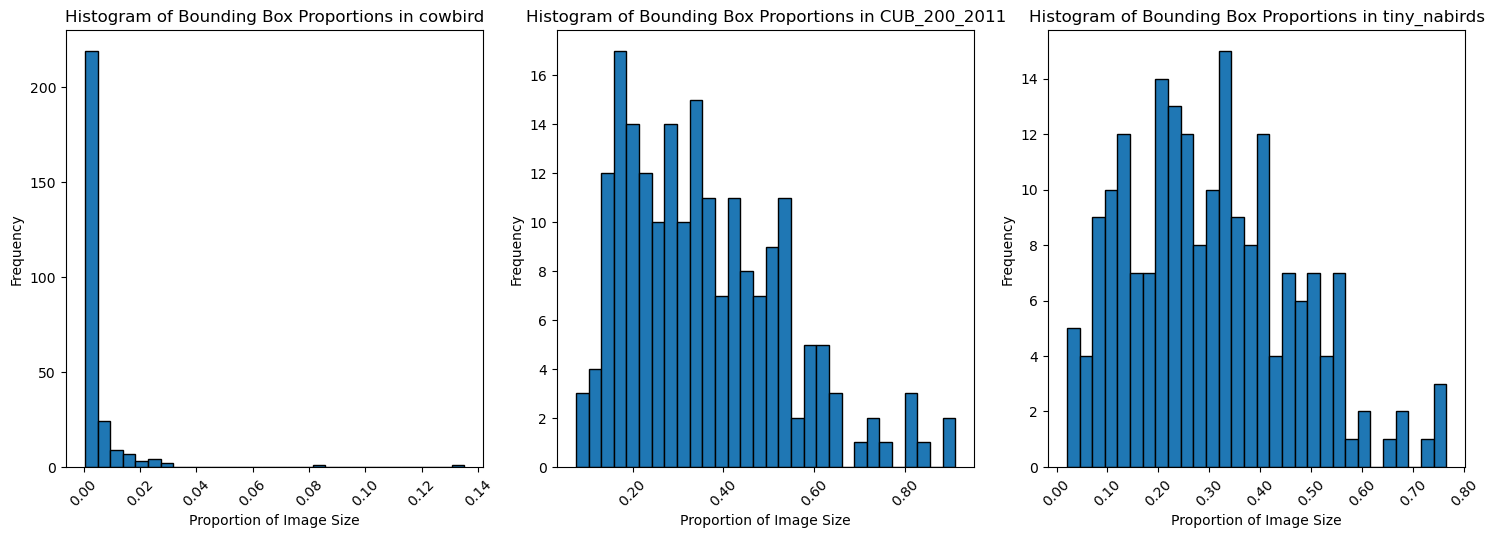

In [7]:
# Combine train and test proportions
combined_proportions_by_dataset = {}
for dataset in set(train_proportions_by_dataset.keys()).union(test_proportions_by_dataset.keys()):
    combined_proportions_by_dataset[dataset] = train_proportions_by_dataset.get(dataset, []) + test_proportions_by_dataset.get(dataset, [])

# Plot histograms for each dataset in a grid-like format
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, (dataset, proportions) in zip(axes, combined_proportions_by_dataset.items()):
    ax.hist(proportions, bins=30, edgecolor='black')
    ax.set_title(f'Histogram of Bounding Box Proportions in {dataset}')
    ax.set_xlabel('Individual Boundingbox Size as proportion of Image Size')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on x-axis
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(combined_proportions_by_dataset), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


The first set of plots reflect the proportion of individual bboxes as a proportion of image sizes. 

From visual inspection of the datasets (see Task 4), the cowbird dataset contains images of multiple birds in larger enclosures, while the remaining datasets depict individual birds in close-ups. Thus, for the cowbird dataset each individual bird in the image is smaller, which is depicted in the plot, with most bounding boxes making up less than 2% of total image size. For the CUB_200_2011 and tiny_nabirds datasets, there is some variability in the bird size, but their bounding boxes typically make up ~30% of total image size.

In [8]:
#Prepare data using bbox sum per picture extraction method
train_sum_proportions_by_dataset = sum_bbox_proportions(train_data)
test_sum_proportions_by_dataset = sum_bbox_proportions(test_data)

({'tiny_nabirds': [0.30307206840390877,
   0.1302994011976048,
   0.5442335979953029,
   0.08642292580409357,
   0.10293496621621621,
   0.2849987360050046,
   0.24206149193548387,
   0.3032605463030747,
   0.46162109375,
   0.2965547218155198,
   0.1812744140625,
   0.3363203813325991,
   0.25946206011730205,
   0.354936859443631,
   0.2576234879032258,
   0.4128421052631579,
   0.38864290404820767,
   0.12181640625,
   0.38796586411609496,
   0.23511022514071295,
   0.7657872774480712,
   0.11523151537335286,
   0.33961411583438683,
   0.3606104252400549,
   0.3223348847517731,
   0.27356313961988304,
   0.3806800895340751,
   0.24737198565323565,
   0.3006361607142857,
   0.43618457174231334,
   0.12092496141975309,
   0.4635840108401084,
   0.35400390625,
   0.08154419867758186,
   0.5297547387295082,
   0.45397231158088236,
   0.11002604166666667,
   0.16760465456674473,
   0.19997916666666668,
   0.6763397961128049,
   0.26589586028460543,
   0.4991625,
   0.45860877403846156,
  

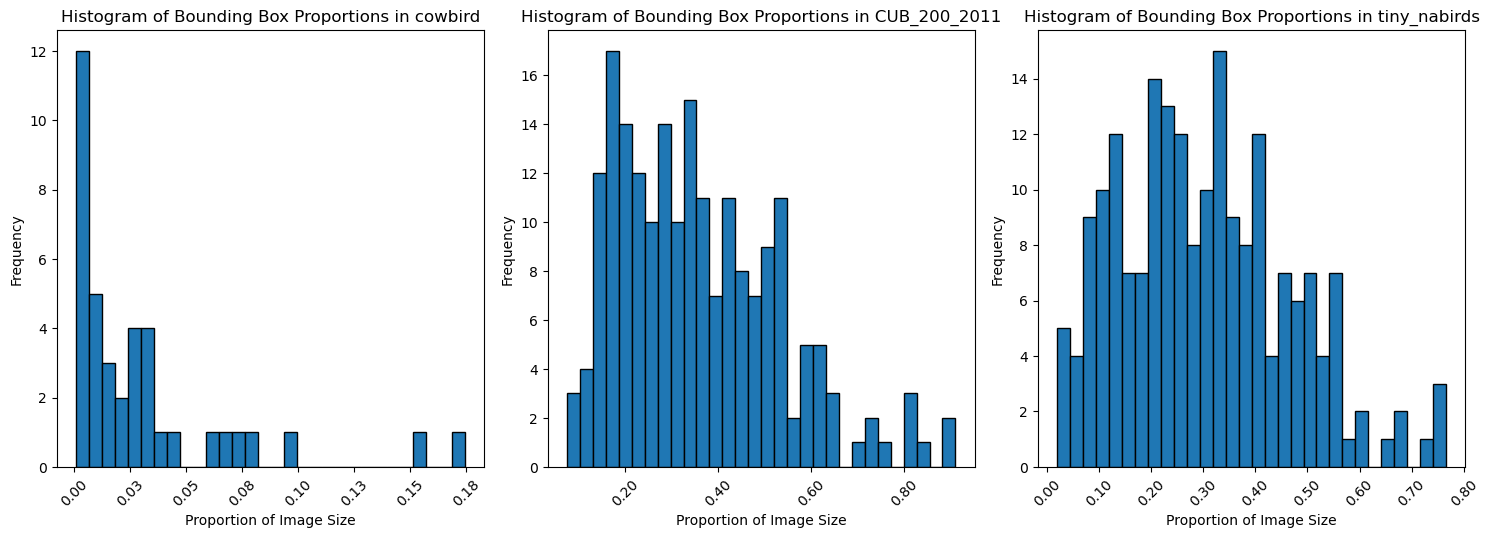

In [9]:
# Combine train and test proportions
combined_sum_proportions_by_dataset = {}
for dataset in set(train_sum_proportions_by_dataset.keys()).union(test_sum_proportions_by_dataset.keys()):
    combined_sum_proportions_by_dataset[dataset] = train_sum_proportions_by_dataset.get(dataset, []) + test_sum_proportions_by_dataset.get(dataset, [])


# Plot histograms for each dataset in a grid-like format
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, (dataset, proportions) in zip(axes, combined_sum_proportions_by_dataset.items()):
    ax.hist(proportions, bins=30, edgecolor='black')
    ax.set_title(f'Histogram of Bounding Box Proportions in {dataset}')
    ax.set_xlabel('Boundingbox Size Sum as proportion of Image Size')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on x-axis
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(combined_sum_proportions_by_dataset), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


The second set of plots reflect total boundingbox size sum as a proportion of total image size. 
As the CUB_200_2011 and tiny_nabirds datasets depict one bird per image, the plots do not change.
For the cowbird dataset, summing the boundingbox sizes show that the total image size is made up of less than 20% of bounding box size, and the majority of images are made up of less than 5% of bounding boxes.

# Task 3

<Axes: xlabel='Width', ylabel='Height'>

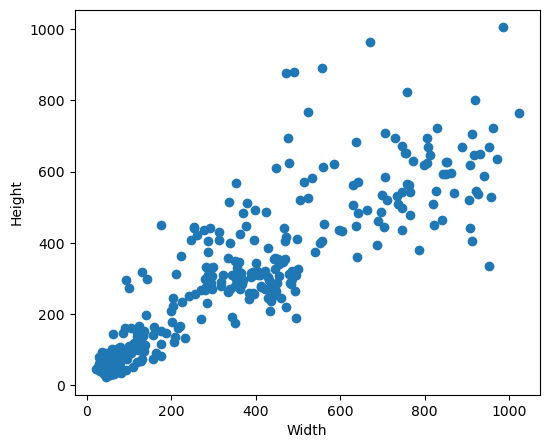

In [10]:
bbox_widths, bbox_heights = calculate_width_height(train_data)
plot_width_height(bbox_widths, bbox_heights)

<Axes: xlabel='Area (width * height)', ylabel='Frequency'>

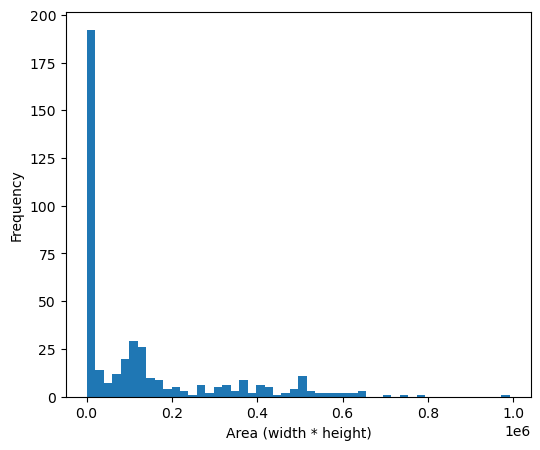

In [11]:
bbox_area = calculate_area(bbox_widths, bbox_heights)
plot_area(bbox_area)

<Axes: xlabel='Ratio (width / height)', ylabel='Frequency'>

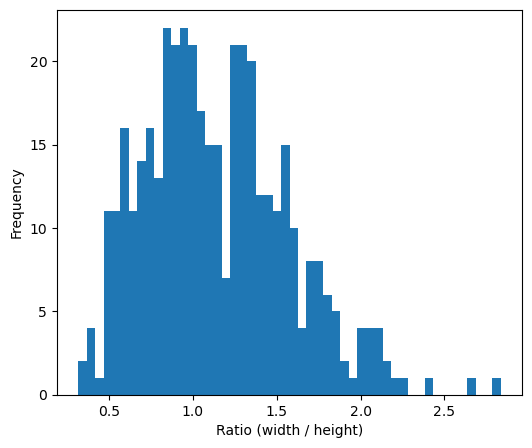

In [12]:
bbox_ratio = calculate_ratio(bbox_widths, bbox_heights)
plot_ratio(bbox_ratio)

12620 instances have been found with visibility value of (-1)


(40.91862416107382, 38.92617449664429, 20.155201342281877)

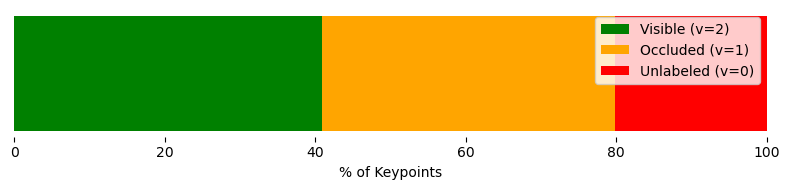

In [13]:
percent_visible, percent_occluded, percent_unlabeled = compute_keypoints(train_data)
plot_keypoint_percent(percent_visible, percent_occluded, percent_unlabeled)
percent_visible, percent_occluded, percent_unlabeled 

## Interactive Image, Keypoint, and Bbox visualiser

This section involves visualizing the boundboxes and key points across datasets.
This is accomplished using the [Visualiser.py ](Visualiser.py) file.
By running the script,
```bash
python analysis_pipeline/Visualiser.py
```
a pop-up window appears, allowing the user to browse through images and their bounding boxes and keypoints using they keyboard left & right arrows.

The script takes the test set from the merged superbird dataset. To browse through training data, change the annotation_path to the train.json annotations. 

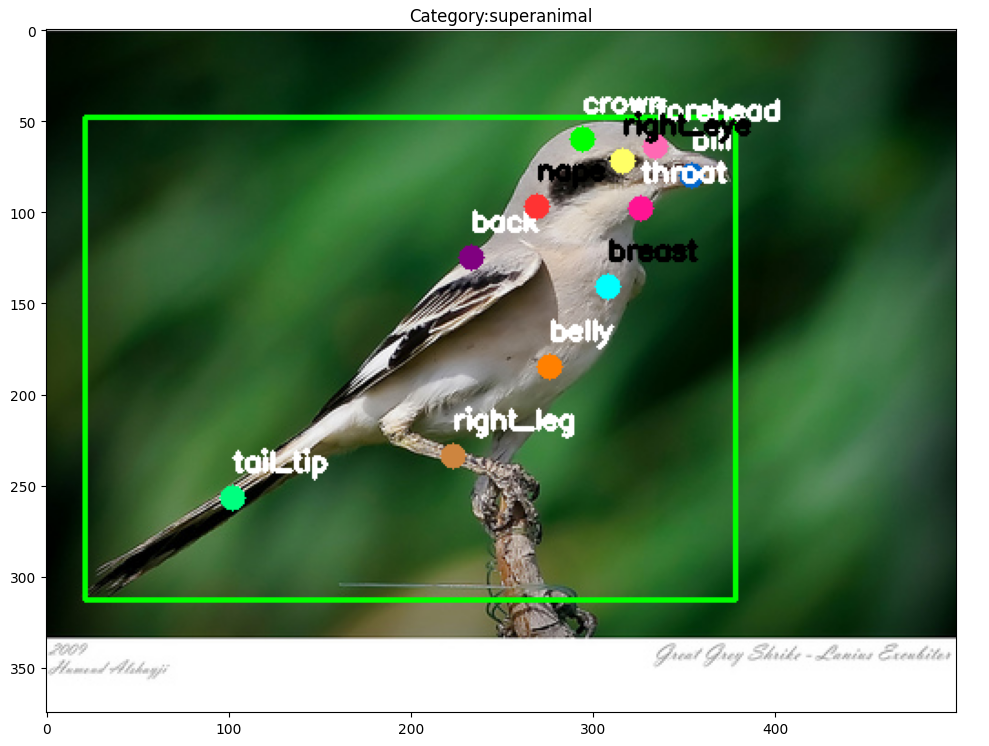

# Pose clustering & outlier analysis

In this section, we represent each set of keypoints by the vector composed of the annotation (x, y, visibility) attributes for each individual bodypart. 
Thus, for a set of keypoints S={beak, belly, neck}, the representing vector would be V=(x_beak, y_beak, v_beak, x_belly, y_belly, v_belly, x_neck, y_neck, v_neck) 

In [6]:
all_keypoints = get_all_keypoints(train_data)  # load all keypoint annotations
parsed_poses = keypoint2pose(all_keypoints)  # parse keypoint annotations into (x, y, visibility) triples
parsed_poses.shape

(414, 126)

In [7]:
poses_df = pd.DataFrame(parsed_poses)
poses_df

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,0.0,0.0,0.0,160.0,358.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,257.0,328.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,391.0,325.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,426.0,332.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,364.0,410.0,0.0,139.0,186.0,0.0,357.0,639.0,0.0,293.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,437.0,208.0,0.0,657.0,210.0,0.0,422.0,408.0,0.0,526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,0.0,0.0,0.0,305.0,156.0,0.0,238.0,182.0,0.0,266.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,514.0,304.0,0.0,328.0,271.0,0.0,538.0,415.0,0.0,435.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# drop all zero features: keypoints that are never annotated
poses_df = poses_df.loc[:, (poses_df != 0).any(axis=0)]
poses_df

,0,1,3,4,5,6,7,9,10,12,...,49,51,52,53,69,70,71,72,73,74
0,0.0,0.0,160.0,358.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,168.0,364.0,2.0,168.0,399.0,2.0,182.0,399.0,2.0
1,0.0,0.0,257.0,328.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,271.0,339.0,2.0,279.0,387.0,2.0,289.0,389.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,353.0,334.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,391.0,325.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,375.0,367.0,2.0,367.0,364.0,2.0
4,0.0,0.0,426.0,332.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,420.0,337.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,364.0,410.0,139.0,186.0,0.0,357.0,639.0,293.0,469.0,290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,437.0,208.0,657.0,210.0,0.0,422.0,408.0,526.0,333.0,553.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,0.0,0.0,305.0,156.0,0.0,238.0,182.0,266.0,158.0,293.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,514.0,304.0,328.0,271.0,0.0,538.0,415.0,435.0,382.0,429.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


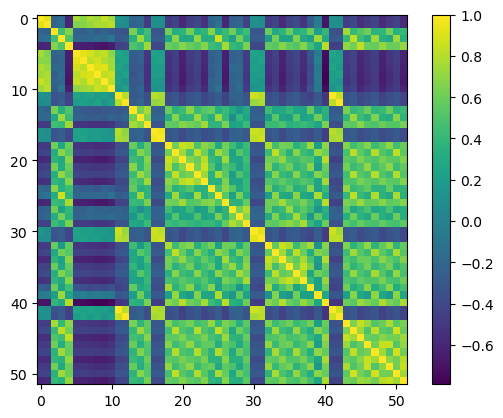

In [9]:
# compute correlation between remaining features
corr = np.corrcoef(poses_df.T)
plt.imshow(corr)
plt.colorbar()

### PCA

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(poses_df)

In [11]:
pca_3d = PCA(n_components=3)
pca_2d = PCA(n_components=2)

p_comp_2d = pca_2d.fit_transform(scaled_features)
p_comp_3d = pca_3d.fit_transform(scaled_features)

p_comp_2d.shape, p_comp_3d.shape

((414, 2), (414, 3))

### KMeans clustering

#### Kmeans on 2d features

##### Deciding on number of clusters: elbow method

In [12]:
sse = [] # sum of squared error within clusters
for k in range(1, 15):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=50, random_state=42)
    # run Kmeans algo
    kmeans.fit(p_comp_2d)
    sse.append(kmeans.inertia_)

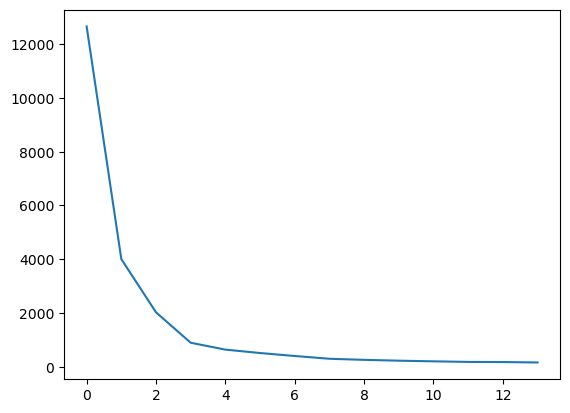

In [13]:
plt.plot(sse)

In [14]:
from kneed import KneeLocator

opt_clusters = KneeLocator(range(1,15), sse, curve="convex", direction="decreasing")
f"Optimal number of clusters: {opt_clusters.knee}"

'Optimal number of clusters: 4'

In [15]:
kmeans = KMeans(init="random", n_clusters=opt_clusters.knee, n_init=10, max_iter=50, random_state=42)
# run Kmeans algo
kmeans.fit(p_comp_2d)

predicted_labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [16]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(p_comp_2d, predicted_labels)
predicted_clusters

,0,1,label
3,-0.006787,0.560821,3
3,2.449607,0.411817,3
3,-0.402650,0.643910,3
3,1.341815,0.619687,3
3,0.271036,0.516926,3
...,...,...,...
1,-4.467823,-4.027202,1
1,-4.408312,-3.744752,1
1,-3.339419,-1.204283,1
1,-4.626191,-4.027216,1


Text(0.5, 1.0, 'Train keypoints: 4 clusters')

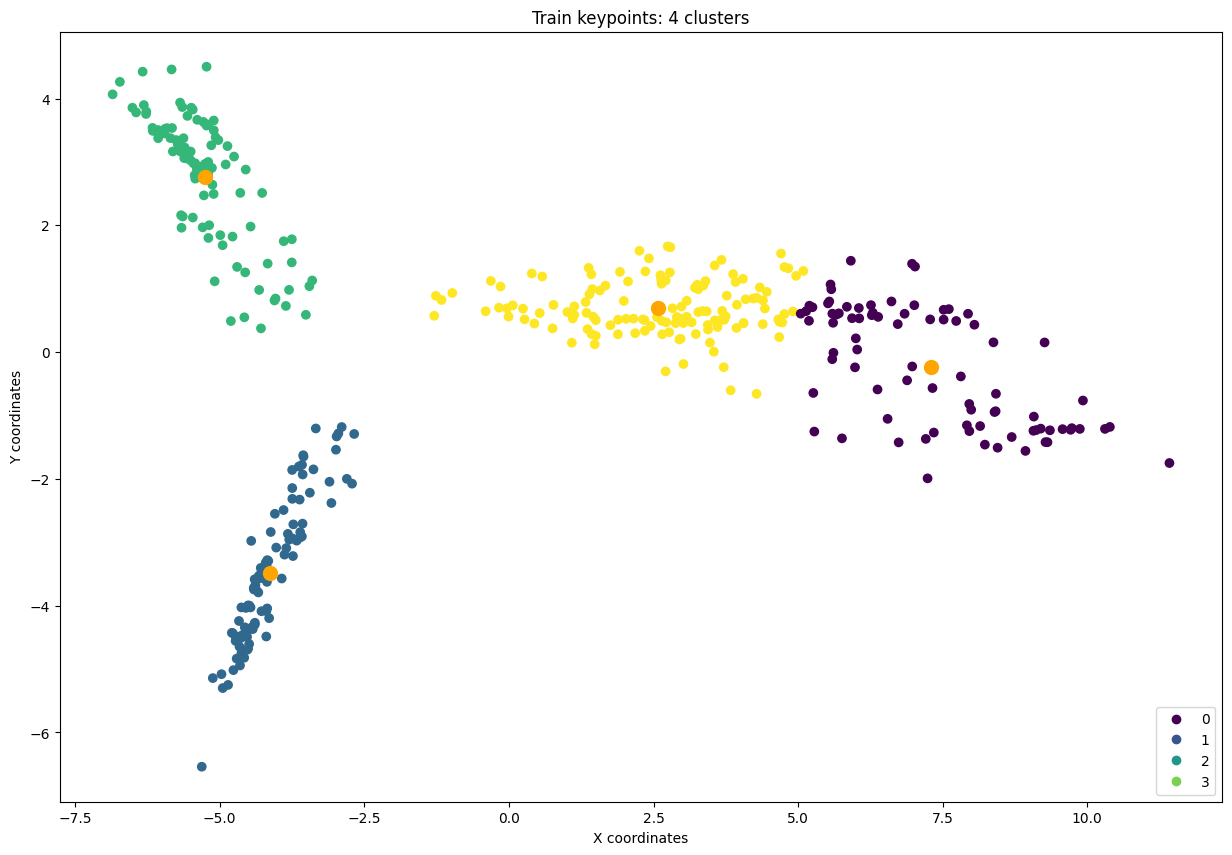

In [17]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(predicted_clusters[0], predicted_clusters[1], c=predicted_clusters["label"])
scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="orange", s=100)
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

unique_labels = np.unique(predicted_clusters["label"])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(handles, unique_labels, loc="lower right")
plt.title(f"Train keypoints: {opt_clusters.knee} clusters")

#### Kmeans on 3d features

In [18]:
sse = [] # sum of squared error within clusters
for k in range(1, 15):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=50, random_state=42)
    # run Kmeans algo
    kmeans.fit(p_comp_3d)
    sse.append(kmeans.inertia_)

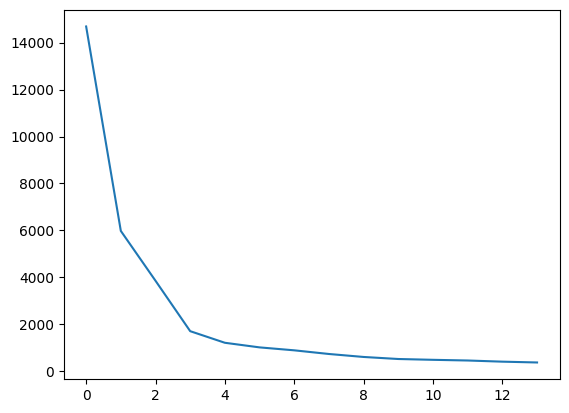

In [19]:
plt.plot(sse)

In [20]:
from kneed import KneeLocator

opt_clusters = KneeLocator(range(1,15), sse, curve="convex", direction="decreasing")
f"Optimal number of clusters: {opt_clusters.knee}"

'Optimal number of clusters: 4'

In [21]:
kmeans = KMeans(init="random", n_clusters=opt_clusters.knee, n_init=10, max_iter=50, random_state=42)
# run Kmeans algo
kmeans.fit(p_comp_3d)

predicted_labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [22]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(p_comp_3d, predicted_labels)
predicted_clusters

,0,1,2,label
3,-0.006787,0.560821,-0.939724,3
3,2.449607,0.411817,-0.268492,3
3,-0.402650,0.643910,-1.652101,3
3,1.341815,0.619687,-1.302087,3
3,0.271036,0.516926,-1.538147,3
...,...,...,...,...
1,-4.467823,-4.027202,0.194285,1
1,-4.408312,-3.744752,-0.273688,1
1,-3.339419,-1.204283,-1.303910,1
1,-4.626191,-4.027216,-0.329286,1


In [23]:
import plotly.express as px

fig = px.scatter_3d(predicted_clusters, x=0, y=1, z=2, color='label')
fig.show()

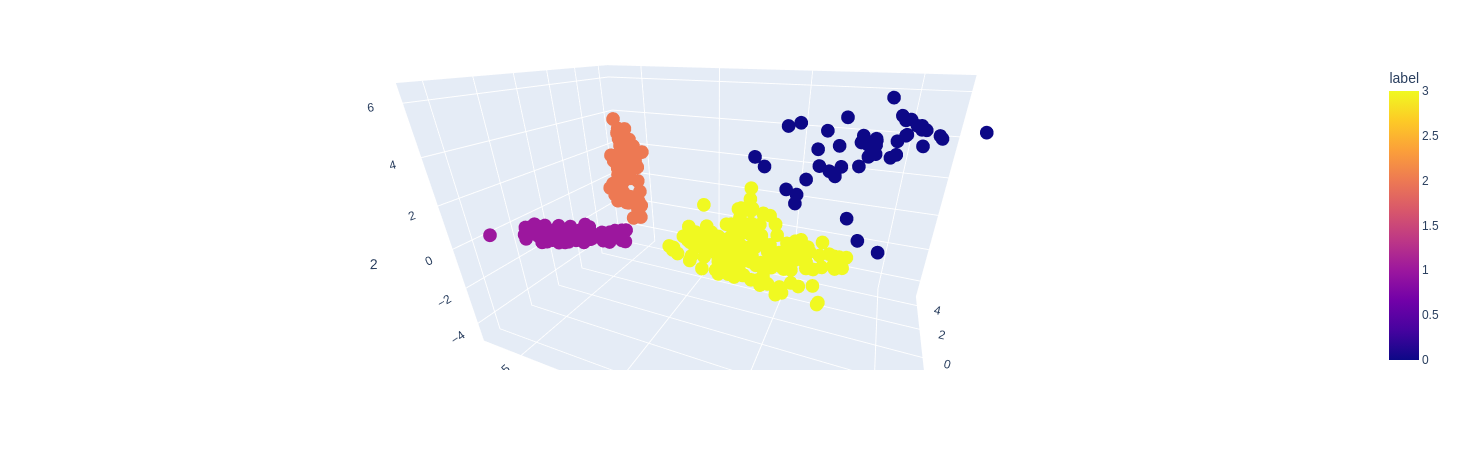

### Next steps
- Visualise images/poses in each cluster 
- Try & compare to other dimensionality reduction techniques: tSNE, Umap